In [ ]:
!pip install torch torchvision tqdm matplotlib

In [ ]:
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# 📁 Input Paths (your raw dataset)
input_image_dir = '/content/drive/MyDrive/glacial_lake_dataset/images'
input_mask_dir = '/content/drive/MyDrive/glacial_lake_dataset/masks'

# ✅ Output Paths (save resized data to Drive)
output_image_dir = '/content/drive/MyDrive/glacial_data/processed/train/images'
output_mask_dir = '/content/drive/MyDrive/glacial_data/processed/train/masks'

# 🔨 Create output folders if they don’t exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# 🔄 Resize and Normalize
resize_size = (256, 256)
img_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor()  # Normalize to [0, 1]
])
mask_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor()
])

# 🌀 Preprocess images and masks
image_files = sorted(os.listdir(input_image_dir))

for file in tqdm(image_files):
    if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img_path = os.path.join(input_image_dir, file)
    mask_path = os.path.join(input_mask_dir, file)

    if not os.path.exists(mask_path):
        print(f"⚠️ Mask not found for {file}")
        continue

    # Open image and mask
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')

    # Resize and convert to tensor
    img_tensor = img_transform(img)
    mask_tensor = mask_transform(mask)

    # Convert back to PIL for saving
    img_out = transforms.ToPILImage()(img_tensor)
    mask_out = transforms.ToPILImage()(mask_tensor)

    # Save to Drive
    img_out.save(os.path.join(output_image_dir, file))
    mask_out.save(os.path.join(output_mask_dir, file))

print("✅ Dataset preprocessing complete and saved to Google Drive.")


 81%|████████  | 340/420 [04:59<01:07,  1.18it/s]

⚠️ Mask not found for image_405(1).png


 81%|████████▏ | 342/420 [04:59<00:48,  1.61it/s]

⚠️ Mask not found for image_406(1).png


 82%|████████▏ | 344/420 [05:00<00:39,  1.91it/s]

⚠️ Mask not found for image_407(1).png


 82%|████████▏ | 346/420 [05:01<00:36,  2.05it/s]

⚠️ Mask not found for image_408(1).png


 83%|████████▎ | 348/420 [05:02<00:33,  2.13it/s]

⚠️ Mask not found for image_409(1).png


 83%|████████▎ | 350/420 [05:03<00:31,  2.25it/s]

⚠️ Mask not found for image_41(1).png


 84%|████████▍ | 352/420 [05:03<00:28,  2.38it/s]

⚠️ Mask not found for image_410(1).png


 84%|████████▍ | 354/420 [05:04<00:28,  2.35it/s]

⚠️ Mask not found for image_42(1).png


 85%|████████▍ | 356/420 [05:05<00:27,  2.36it/s]

⚠️ Mask not found for image_43(1).png


 85%|████████▌ | 358/420 [05:07<00:31,  1.99it/s]

⚠️ Mask not found for image_44(1).png


100%|██████████| 420/420 [05:58<00:00,  1.17it/s]

✅ Dataset preprocessing complete and saved to Google Drive.


In [ ]:
from IPython.display import Image as ColabImage, display

sample_file = sorted(os.listdir(output_image_dir))[0]

display(Image.open(os.path.join(output_image_dir, sample_file)))
display(Image.open(os.path.join(output_mask_dir, sample_file)))


NameError: name 'output_image_dir' is not defined

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))

        # Bottleneck
        b = self.bottleneck(self.pool3(e3))

        # Decoder
        d3 = self.upconv3(b)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.final(d1))  # Output in [0, 1]


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as transforms

class GlacialLakeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        # Apply transform (ToTensor)
        image = self.transform(image)
        mask = self.transform(mask)

        return image, mask


In [ ]:
from torch.utils.data import DataLoader

# Paths to processed data
image_dir = "/content/drive/MyDrive/glacial_data/processed/train/images"
mask_dir = "/content/drive/MyDrive/glacial_data/processed/train/masks"

# Create dataset and loader
dataset = GlacialLakeDataset(image_dir, mask_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
images, masks = next(iter(dataloader))
print("Image batch shape:", images.shape)  # [B, 3, 256, 256]
print("Mask batch shape:", masks.shape)    # [B, 1, 256, 256]


Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


In [ ]:
 from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Path to save model inside Google Drive
save_path = "/content/drive/MyDrive/glacial_unet/unet_model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model
model = UNet().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

# 🔒 Save model permanently
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved permanently to {save_path}")


Using device: cuda


Epoch [1/10]: 100%|██████████| 103/103 [02:43<00:00,  1.59s/it, loss=0.159]


Epoch [1/10], Loss: 0.2920


Epoch [2/10]: 100%|██████████| 103/103 [00:20<00:00,  4.97it/s, loss=0.0245]


Epoch [2/10], Loss: 0.0892


Epoch [3/10]: 100%|██████████| 103/103 [00:21<00:00,  4.85it/s, loss=0.0447]


Epoch [3/10], Loss: 0.0719


Epoch [4/10]: 100%|██████████| 103/103 [00:20<00:00,  4.91it/s, loss=0.027]


Epoch [4/10], Loss: 0.0650


Epoch [5/10]: 100%|██████████| 103/103 [00:20<00:00,  4.95it/s, loss=0.043]


Epoch [5/10], Loss: 0.0587


Epoch [6/10]: 100%|██████████| 103/103 [00:20<00:00,  4.94it/s, loss=0.0583]


Epoch [6/10], Loss: 0.0550


Epoch [7/10]: 100%|██████████| 103/103 [00:20<00:00,  4.95it/s, loss=0.096]


Epoch [7/10], Loss: 0.0520


Epoch [8/10]: 100%|██████████| 103/103 [00:21<00:00,  4.89it/s, loss=0.0571]


Epoch [8/10], Loss: 0.0528


Epoch [9/10]: 100%|██████████| 103/103 [00:20<00:00,  4.94it/s, loss=0.0397]


Epoch [9/10], Loss: 0.0495


Epoch [10/10]: 100%|██████████| 103/103 [00:20<00:00,  4.96it/s, loss=0.0226]


Epoch [10/10], Loss: 0.0487
✅ Model saved permanently to /content/drive/MyDrive/glacial_unet/unet_model.pth


In [ ]:
model = UNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/glacial_unet/unet_model.pth", map_location=torch.device('cpu')))
model.eval()


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequen

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

# Load one image
test_image_path = "/content/drive/MyDrive/Glacial_Lake_Test_Images/glacialimage.png"  # change name if needed
original = Image.open(test_image_path).convert("RGB")

# Transform it
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
input_tensor = transform(original).unsqueeze(0)  # [1, 3, 256, 256]


In [ ]:
model = UNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/glacial_unet/unet_model.pth", map_location=torch.device("cpu")))
model.eval()


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequen

In [ ]:
with torch.no_grad():
    output = model(input_tensor)  # Shape: [1, 1, 256, 256]
    predicted_mask = output.squeeze().numpy()  # Shape: [256, 256]


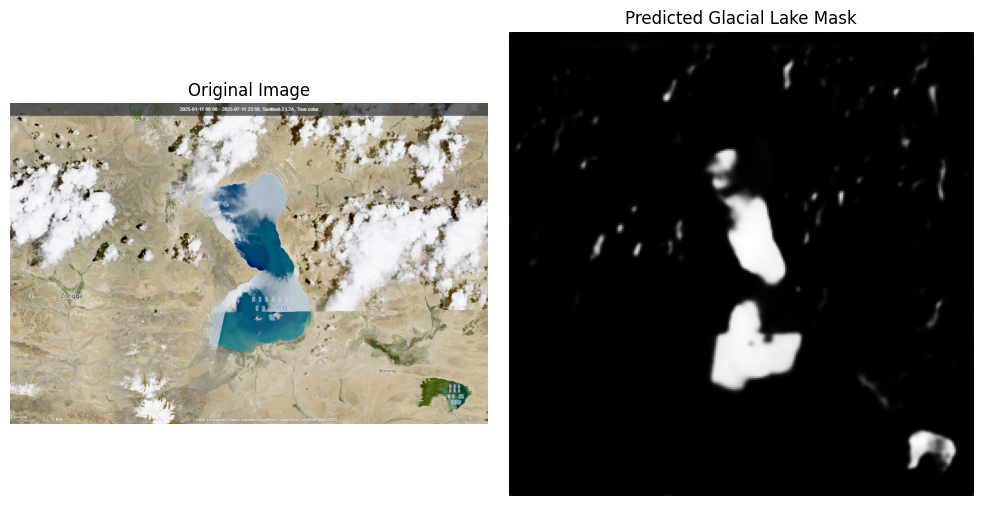

In [ ]:
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Glacial Lake Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Example paths to your time-based images
img_path_2020 = "/content/drive/MyDrive/Glacial_Lake_Test_Images/image_2020.png"
img_path_2024 = "/content/drive/MyDrive/Glacial_Lake_Test_Images/image_2024.png"


In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def load_and_predict(image_path, model):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        mask = output.squeeze().numpy()
    return image, mask


In [ ]:
# Load model
model = UNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/glacial_unet/unet_model.pth", map_location=torch.device("cpu")))

# Get masks
img_2020, mask_2020 = load_and_predict(img_path_2020, model)
img_2024, mask_2024 = load_and_predict(img_path_2024, model)


In [ ]:
# Load model
model = UNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/glacial_unet/unet_model.pth", map_location=torch.device("cpu")))

# Get masks
img_2020, mask_2020 = load_and_predict(img_path_2020, model)
img_2024, mask_2024 = load_and_predict(img_path_2024, model)


In [ ]:
import numpy as np

# Step 1: Count lake area from binary masks
# Convert masks to binary (e.g., threshold at 0.5)
bin_mask_2020 = (mask_2020 > 0.5).astype(np.uint8)
bin_mask_2024 = (mask_2024 > 0.5).astype(np.uint8)

area_2020_pixels = int(np.sum(bin_mask_2020))  # number of lake pixels in 2020
area_2024_pixels = int(np.sum(bin_mask_2024))  # number of lake pixels in 2024

# Step 2: Convert pixels to square feet
# Sentinel-2 resolution: 10m x 10m → 100 sq meters per pixel
# 1 sq meter = 10.7639 sq feet
sq_feet_per_pixel = 100 * 10.7639  # ≈ 1076.39 sq ft

area_2020_sqft = area_2020_pixels * sq_feet_per_pixel
area_2024_sqft = area_2024_pixels * sq_feet_per_pixel

# Step 3: Compute change
change_sqft = area_2024_sqft - area_2020_sqft
percent_change = (change_sqft / area_2020_sqft) * 100

# Step 4: Print results
print(f"Lake Area in 2020: {area_2020_sqft:.2f} sq ft")
print(f"Lake Area in 2024: {area_2024_sqft:.2f} sq ft")

if change_sqft >= 0:
    print(f"✅ Lake increased by {change_sqft:.2f} sq ft ({percent_change:.2f}%)")
else:
    print(f"⚠️ Lake decreased by {abs(change_sqft):.2f} sq ft ({abs(percent_change):.2f}%)")

Lake Area in 2020: 6723131.94 sq ft
Lake Area in 2024: 8881293.89 sq ft
✅ Lake increased by 2158161.95 sq ft (32.10%)


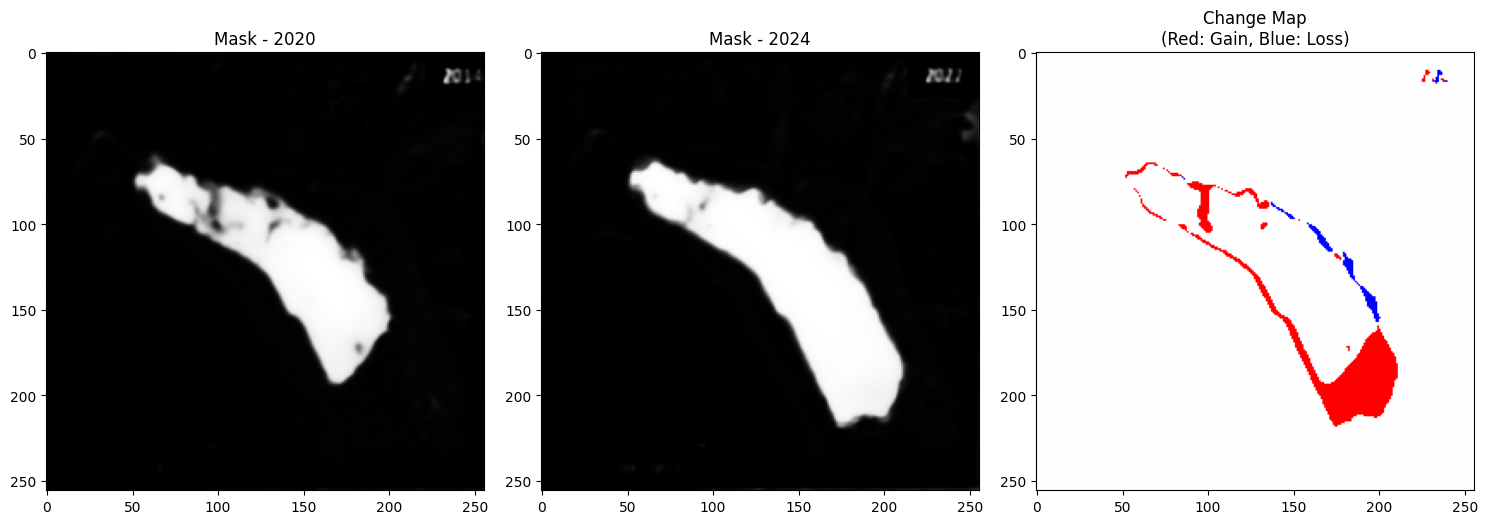

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(mask_2020, cmap='gray')
plt.title("Mask - 2020")

plt.subplot(1, 3, 2)
plt.imshow(mask_2024, cmap='gray')
plt.title("Mask - 2024")

# Calculate the change mask
change_mask = bin_mask_2024.astype(np.int8) - bin_mask_2020.astype(np.int8)

plt.subplot(1, 3, 3)
plt.imshow(change_mask, cmap='bwr')
plt.title("Change Map\n(Red: Gain, Blue: Loss)")

plt.tight_layout()
plt.show()

Date: 2025-07-26_15-32-58
Lake Area: 8881293.89 sq ft
Risk Level: Moderate risk (+32.10%)
Mask saved to: /content/drive/MyDrive/MyDrive/glacial_unet/masks/mask_2025-07-26_15-32-58.png


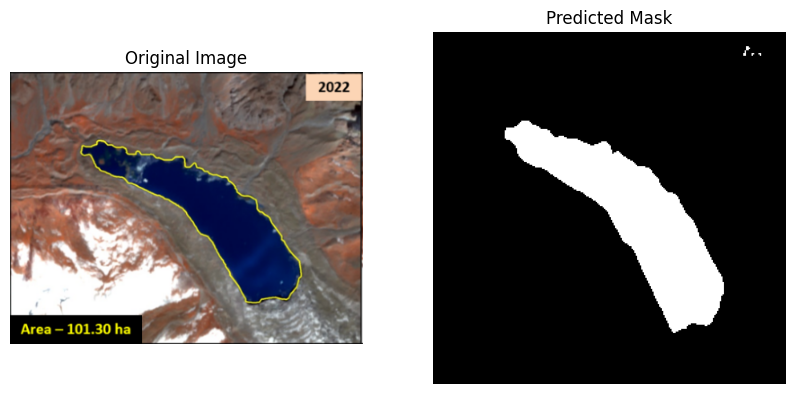

In [ ]:
import os
import cv2
import csv
import numpy as np
from datetime import datetime
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import requests

# === Telegram Bot Setup ===
BOT_TOKEN = "8407569182:AAHQKRjpFY5jIDSDql1jgDUCvPQCOSWB9h4"
CHAT_ID = "1802159603"

def send_telegram_alert(message):
    url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage"
    data = {"chat_id": CHAT_ID, "text": message}
    try:
        requests.post(url, data=data)
    except Exception as e:
        print(f"Error sending Telegram alert: {e}")


# === Paths ===
results_csv = "/content/drive/MyDrive/glacial_unet/lake_area_records.csv"
mask_output_dir = "/content/drive/MyDrive/MyDrive/glacial_unet/masks"
os.makedirs(mask_output_dir, exist_ok=True)

# === Function: Predict mask ===
def predict_mask(image_path, model):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)
        mask = output.squeeze().numpy()

    return np.where(mask > 0.5, 1, 0), image

# === Function: Compute area (sq ft) ===
def compute_area(mask):
    pixel_count = np.sum(mask)
    sq_feet_per_pixel = 100 * 10.7639  # Sentinel-2 resolution
    return pixel_count * sq_feet_per_pixel

# === Function: Get last record ===
def get_last_record():
    if not os.path.exists(results_csv):
        return None
    with open(results_csv, "r") as f:
        rows = list(csv.reader(f))
        if len(rows) <= 1:  # Only header
            return None
        return rows[-1]  # Last row

# === Function: Save new record ===
def save_record(date, area, mask_path, risk):
    write_header = not os.path.exists(results_csv)
    with open(results_csv, "a", newline="") as f:
        writer = csv.writer(f)
        if write_header:
            writer.writerow(["Date", "Lake_Area_sqft", "Mask_Path", "Risk"])
        writer.writerow([date, area, mask_path, risk])

# === Risk classification ===
def classify_risk(current_area, prev_area):
    if prev_area is None:
        return "No previous data"
    change = ((current_area - prev_area) / prev_area) * 100
    if change > 50:
        return f"⚠️ High risk (+{change:.2f}%)"
    elif change > 20:
        return f"Moderate risk (+{change:.2f}%)"
    elif change < -10:
        return f"Lake Shrinking ({change:.2f}%)"
    else:
        return f"Safe (+{change:.2f}%)"

# === MAIN: Predict and Save ===
def process_new_image(image_path, model):
    today = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Predict mask
    mask, original_img = predict_mask(image_path, model)
    area_sqft = compute_area(mask)

    # Save mask image
    mask_filename = f"mask_{today}.png"
    mask_save_path = os.path.join(mask_output_dir, mask_filename)
    cv2.imwrite(mask_save_path, (mask * 255).astype(np.uint8))

    # Get last record
    last = get_last_record()
    prev_area = float(last[1]) if last else None

    # Risk classification
    risk = classify_risk(area_sqft, prev_area)

    # Save record
    save_record(today, area_sqft, mask_save_path, risk)

    # Display
    print(f"Date: {today}")
    print(f"Lake Area: {area_sqft:.2f} sq ft")
    print(f"Risk Level: {risk}")
    print(f"Mask saved to: {mask_save_path}")

    # Send Telegram alert if risk is high
    if "High risk" in risk:
        send_telegram_alert(f"🚨 Glacial Lake Alert!\nDate: {today}\nRisk: {risk}\nArea: {area_sqft:.2f} sq ft")

    # Show images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()


# === RUN FOR NEW IMAGE ===
new_image_path = "/content/drive/MyDrive/Glacial_Lake_Test_Images/image_2024.png"  # change
process_new_image(new_image_path, model)